# NFL EDA

# import libraries

In [1]:
import os

import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt

# deep learning
# import timm
from torch.cuda.amp import autocast, GradScaler
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts, OneCycleLR, CosineAnnealingLR, ReduceLROnPlateau, StepLR, LambdaLR
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# augmentation
# from albumentations.pytorch import ToTensorV2
# import albumentations as A



# Set Configurations

In [2]:
kaggle = False
class CFG:
    if kaggle:
        BASE_DIR = "/kaggle/input/nfl-player-contact-detection"
    else:
        BASE_DIR = "/workspace/input"
    TRAIN_HELMET_CSV = os.path.join(BASE_DIR, "train_baseline_helmets.csv")
    TRAIN_TRACKING_CSV = os.path.join(BASE_DIR, "train_player_tracking.csv")
    TRAIN_VIDEO_META_CSV = os.path.join(BASE_DIR, "train_video_metadata.csv")
    TRAIN_LABEL_CSV = os.path.join(BASE_DIR, "train_labels.csv")
    
    img_size = (256, 256)
    
    batch_size = 8
    num_workers = 0
    

# Utils

In [3]:
def add_contact_id(df):
    # Create contact ids
    df["contact_id"] = (
        df["game_play"]
        + "_"
        + df["step"].astype("str")
        + "_"
        + df["nfl_player_id_1"].astype("str")
        + "_"
        + df["nfl_player_id_2"].astype("str")
    )
    return df

def expand_contact_id(df):
    """
    Splits out contact_id into seperate columns.
    """
    df["game_play"] = df["contact_id"].str[:12]
    df["step"] = df["contact_id"].str.split("_").str[-3].astype("int")
    df["nfl_player_id_1"] = df["contact_id"].str.split("_").str[-2]
    df["nfl_player_id_2"] = df["contact_id"].str.split("_").str[-1]
    return df


In [4]:
def get_snap_frame(row):
    elaped_time_start2snap = row.snap_time - row.start_time
    elaped_seconds = elaped_time_start2snap.seconds
    snap_frame = elaped_seconds*59.95
    return snap_frame

# Read Data

In [5]:
helmet_df = pd.read_csv(CFG.TRAIN_HELMET_CSV)
tracking_df = pd.read_csv(CFG.TRAIN_TRACKING_CSV)
videometa_df = pd.read_csv(CFG.TRAIN_VIDEO_META_CSV, parse_dates=["start_time", "end_time", "snap_time"])
target_df = pd.read_csv(CFG.TRAIN_LABEL_CSV, parse_dates=["datetime"])

In [6]:
videometa_df["snap_frame"] = videometa_df.apply(get_snap_frame, axis=1)
helmet_df = helmet_df[['game_play', 'view', 'frame', 'nfl_player_id', 'left', 'width', 'top', 'height']]

# check target data

In [7]:
# def get_window_from_center(center_pos, window_size=(100, 100), img_size=(720, 1280)):
#     top = int(center_pos[0] - (window_size[0]//2))
#     bot = int(center_pos[0] + (window_size[0]//2))
#     left = int(center_pos[1] - (window_size[1]//2))
#     right = int(center_pos[1] + (window_size[1]//2))
#     # set crop area (minimum >= 0 & maximum <= img_size) 
#     crop_top = max(0, top)
#     crop_left = max(0, left)
#     crop_bot = min(img_size[0], bot)
#     crop_right = min(img_size[1], right)
#     if crop_top != top:    crop_bot = bot - top
#     if crop_left != left:   crop_right = right - left
#     if crop_bot != bot:    crop_top = crop_top - (crop_bot - img_size[0])
#     if crop_right != right:   crop_left = left - (crop_right - img_size[1])

#     return [crop_left, crop_top, crop_right, crop_bot]

In [8]:
# def get_window_from_lefttop(lefttop_pos, window_size=(100, 100), img_size=(720, 1280)):
#     bot = int(lefttop_pos[0] + window_size[0])
#     right = int(lefttop_pos[1] + window_size[1])
#     # set crop area (minimum >= 0 & maximum <= img_size) 
#     crop_bot = min(img_size[0], bot)
#     crop_right = min(img_size[1], right)
#     if crop_bot != bot:    crop_top = crop_top - (crop_bot - img_size[0])
#     else: crop_top = lefttop_pos[0]
#     if crop_right != right:   crop_right = right - (crop_right - img_size[1])
#     else: crop_left = lefttop_pos[1]
    
#     return [crop_left, crop_top, crop_right, crop_bot]

In [9]:
# def get_helmet_area(helmet_left, helmet_top, helmet_width, helmet_height, window_size=(100, 100), printer=True):
#     if printer:
#         print("helmet pos = ", helmet_left, helmet_top)
#     # get helmet centor
#     helmet_pos = [helmet_left + helmet_width//2, helmet_top + helmet_height//2]
#     helmet_area = get_window_from_center(helmet_pos, window_size)
#     return helmet_area

In [10]:
def set_inimg_window(crop_area, img_size=(720, 1280)):
    left, top, right, bot = crop_area
    # set crop area (area size in img size)
    crop_left = max(0, left)
    crop_top = max(0, top)
    if crop_left != left:   right = right - left
    if crop_top != top:    bot = bot - top
    crop_bot = min(img_size[0], bot)
    crop_right = min(img_size[1], right)
    if crop_bot != bot:    crop_top = crop_top - (bot - img_size[0])
    if crop_right != right:   crop_left = left - (right - img_size[1])
    
    return [crop_left, crop_top, crop_right, crop_bot]

In [11]:
def make_player_mask(img, helmet_pos, img_size=(720, 1280, 3), alpha=0.3):
    crop_size=[-helmet_pos[2], -helmet_pos[3], helmet_pos[2]*3, helmet_pos[3]*6] # helmetの大きさによってplayerの範囲も変更
    base_area = np.array(helmet_pos) + np.array(crop_size) # [left, top, width, height]
    # set players area
    palyer_area = [base_area[0],  base_area[1], base_area[0] + base_area[2], base_area[1] + base_area[3]]
    palyer_area = set_inimg_window(palyer_area)
    mask = np.zeros(img_size, dtype=np.uint8)
    cv2.rectangle(mask, [palyer_area[0], palyer_area[1]], [palyer_area[2], palyer_area[3]], (255, 255, 255), -1)
    # img_with_mask = mask*alpha + (1-alpha)*img
    # img_with_mask = np.clip(img_with_mask, 0, 255).astype(np.uint8)
    mask = np.clip(mask, 0, 1).astype(np.uint8)
    # img_with_mask = img*mask
    # img_with_mask = np.clip(img_with_mask, 0, 255).astype(np.uint8)
    return mask

In [12]:
def get_1player_croparea(helmet_pos, img_size=(720, 1280)):
    crop_size=[-helmet_pos[2]*3, -helmet_pos[3]*4, helmet_pos[2]*6, helmet_pos[3]*6] # helmetの大きさによってplayerの範囲も変更
    players_area = np.array(helmet_pos) + np.array(crop_size) # [left, top, width, height]
    # set players area
    crop_area = [players_area[0],  players_area[1], players_area[0] + players_area[2], players_area[1] + players_area[3]]
    crop_area = set_inimg_window(crop_area)
    return crop_area

In [13]:
def get_2player_croparea(helmet1_pos, helmet2_pos, img_size=(720, 1280)):
    player1_crop_size=[-10, -10, helmet1_pos[2]*4, helmet1_pos[3]*4] # helmetの大きさによってplayerの範囲も変更
    player2_crop_size=[-10, -10, helmet2_pos[2]*4, helmet2_pos[3]*4] # helmetの大きさによってplayerの範囲も変更
    player1_area = np.array(helmet1_pos) + np.array(player1_crop_size) # [left, top, width, height]
    player2_area = np.array(helmet2_pos) + np.array(player2_crop_size) # [left, top, width, height]
    # [left, top, width, height] => [left, top, right, bot]
    player1_crop_area = np.array([player1_area[0], player1_area[1], player1_area[0]+player1_area[2], player1_area[1]+player1_area[3]]) # [left, top, right, bot]
    player2_crop_area = np.array([player2_area[0], player2_area[1], player2_area[0]+player2_area[2], player2_area[1]+player2_area[3]]) # [left, top, right, bot]
    # get min max for set pos in img
    area_min = np.min(np.array([player1_crop_area, player2_crop_area]), axis=0)
    area_max = np.max(np.array([player1_crop_area, player2_crop_area]), axis=0)
    crop_area = [area_min[0], area_min[1], area_max[2], area_max[3]]
    crop_area = set_inimg_window(crop_area)
    return crop_area

In [14]:
def mask_blend(img, mask):
    img = np.clip(img, 0, 255).astype(np.uint8)
    mask = np.clip(mask, 0, 1).astype(np.uint8)
    img = img*mask
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

In [15]:
def search_helmet(helmet_df, player, frame):
    for diff_frame in range(5):
        read_frame = frame + diff_frame
        player_helmet = helmet_df.query('nfl_player_id==@player and frame==@read_frame')
        if len(player_helmet) > 0:
            return player_helmet
        read_frame = frame - diff_frame
        player_helmet = helmet_df.query('nfl_player_id==@player and frame==@read_frame')
        if len(player_helmet) > 0:
            return player_helmet
    return []

# Set Dataset

In [16]:
class NFLDataset(Dataset):
    def __init__(self, game_play, view, target_df, helmet_df, meta_df, transform=None):
        self.target_df = target_df
        self.helmet_df = helmet_df
        self.meta_df = meta_df
        self.transform = transform
        self.game_play = game_play
        video_file = game_play + "_" + view + ".mp4"
        self.view = view
        self.video_path = os.path.join(CFG.BASE_DIR, "train", video_file)
        self.cam = cv2.VideoCapture(self.video_path)

    def __len__(self):
        return len(self.target_df)

    def __getitem__(self, idx):
        target_info = self.target_df.iloc[idx]
        target = target_info.contact
        game_play1, game_play2, step, player1, player2 = target_info.contact_id.split("_")
        # game_play = game_play1 + "_" + game_play2
        # view = "Endzone"
        meta_info = self.meta_df.query('game_play==@self.game_play and view==@self.view')
        snap_frame = int(meta_info.snap_frame)
        read_frame = snap_frame + int(step) 
        # print(read_frame)
        self.cam.set(cv2.CAP_PROP_POS_FRAMES, int(read_frame))
        ret, img = self.cam.read()
        if ret:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = np.clip(img, 0, 255).astype(np.uint8)
            player1 = int(player1)
            helmet_info = self.helmet_df.query('game_play==@game_play and view==@view')
            # player1_helmet = helmet_info.query('nfl_player_id==@player1 and frame==@read_frame')
            player1_helmet = search_helmet(helmet_info, player1, read_frame)
            if player2 == "G":
                if len(player1_helmet) > 0:
                    print("only player1 p2=G")
                    helmet_pos = [player1_helmet.left.values[0], player1_helmet.top.values[0],
                                  player1_helmet.width.values[0], player1_helmet.height.values[0]]
                    crop_area = get_1player_croparea(helmet_pos)
                    mask = make_player_mask(img, helmet_pos)
                    img = mask_blend(img, mask)
                    img = img[crop_area[1]:crop_area[3], crop_area[0]:crop_area[2], :]
                else:
                    print("no player p2=G")
                    pass
            else:
                player2 = int(player2)
                # player2_helmet = helmet_info.query('nfl_player_id==@player2 and frame==@read_frame')
                player2_helmet = search_helmet(helmet_info, player2, read_frame)
                if len(player2_helmet) == 0 and len(player1_helmet)==0:
                    print("no player len0 p2 not G")
                    pass
                elif len(player1_helmet) > 0 and len(player2_helmet) == 0:
                    print("only player1 p2notG")
                    helmet_pos = [player1_helmet.left.values[0], player1_helmet.top.values[0],
                                  player1_helmet.width.values[0], player1_helmet.height.values[0]]
                    # img = make_player_mask(img, helmet_pos)
                    mask = make_player_mask(img, helmet_pos)
                    img = mask_blend(img, mask)
                    crop_area = get_1player_croparea(helmet_pos)
                    img = img[crop_area[1]:crop_area[3], crop_area[0]:crop_area[2], :]                    
                elif len(player2_helmet) > 0 and len(player1_helmet) == 0:
                    print("only player2")
                    helmet_pos = [player2_helmet.left.values[0], player2_helmet.top.values[0],
                                  player2_helmet.width.values[0], player2_helmet.height.values[0]]
                    # img = make_player_mask(img, helmet_pos)
                    mask = make_player_mask(img, helmet_pos)
                    img = mask_blend(img, mask)
                    crop_area = get_1player_croparea(helmet_pos)
                    img = img[crop_area[1]:crop_area[3], crop_area[0]:crop_area[2], :]
                else:
                    print("two players")
                    helmet1_pos = [player1_helmet.left.values[0], player1_helmet.top.values[0],
                                  player1_helmet.width.values[0], player1_helmet.height.values[0]]
                    helmet2_pos = [player2_helmet.left.values[0], player2_helmet.top.values[0],
                                  player2_helmet.width.values[0], player2_helmet.height.values[0]]
                    mask1 = make_player_mask(img, helmet1_pos)
                    mask2 = make_player_mask(img, helmet2_pos)
                    mask = mask1 + mask2
                    img = mask_blend(img, mask)
                    crop_area = get_2player_croparea(helmet1_pos, helmet2_pos)
                    img = img[crop_area[1]:crop_area[3], crop_area[0]:crop_area[2], :]

            img = cv2.resize(img, dsize=CFG.img_size)
            return img, target
        else:
            img = np.zeros(CFG.img_size)
            return img, target

no player len0 p2 not G
no player len0 p2 not G
no player len0 p2 not G
two players
two players
two players
two players
two players
tensor(0)


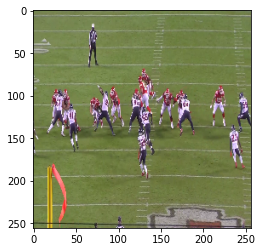

tensor(0)


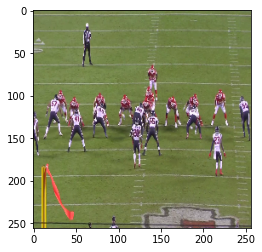

tensor(0)


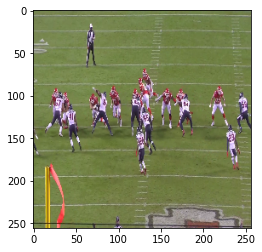

tensor(0)


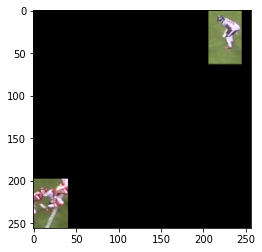

tensor(0)


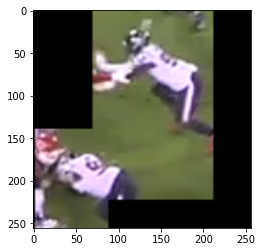

tensor(0)


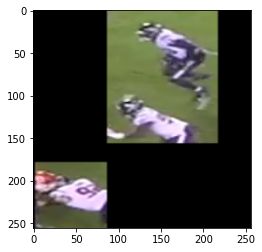

tensor(0)


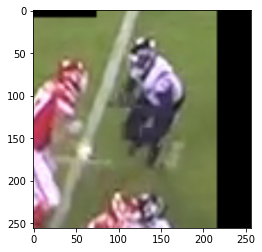

tensor(0)


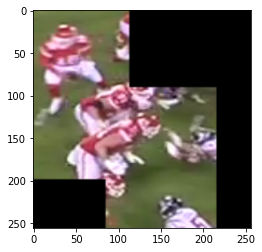

In [20]:
train_videos = [["58168_003392", "Endzone"],["58168_003392", "Sideline"]]

train_dataset = ""
for game_play, view in train_videos:
    target_game = target_df.query('game_play==@game_play')
    helmet_game = helmet_df.query('game_play==@game_play and view==@view')
    videometa_game = videometa_df.query('game_play==@game_play and view==@view')
    train_dataset_tmp = NFLDataset(game_play, view, target_game, helmet_game, videometa_game)
    if len(train_dataset) == 0:
        train_dataset = train_dataset_tmp
    else:
        train_dataset += train_dataset_tmp

train_loader = DataLoader(
    train_dataset,
    batch_size = CFG.batch_size,
    shuffle = True,
    num_workers = CFG.num_workers,
    pin_memory = True
)

for batch_idx, (img, target) in enumerate(train_loader):
    for idx in range(CFG.batch_size):
        plt.imshow(img[idx])
        print(target[idx])
        plt.show()
    break

In [18]:
# p2G_df = target_df.query('nfl_player_id_2!="G"')
# positive_df = target_df.query('contact==1')
# # train_dataset = NFLDataset(target_df, helmet_df, videometa_df)
# train_dataset1 = NFLDataset(p2G_df, helmet_df, videometa_df)
# train_dataset2 = NFLDataset(positive_df, helmet_df, videometa_df)


# train_loader = DataLoader(
#     train_dataset2,
#     # train_dataset1 + train_dataset2,
#     batch_size = CFG.batch_size,
#     shuffle = True,
#     num_workers = CFG.num_workers,
#     pin_memory = True
# )

# for batch_idx, (img, target) in enumerate(train_loader):
#     for idx in range(CFG.batch_size):
#         plt.imshow(img[idx])
#         print(target[idx])
#         plt.show()
#     break

In [19]:
target_df["contact"].value_counts()

0    4657096
1      64522
Name: contact, dtype: int64